<a href="https://colab.research.google.com/github/Ekram-20/CodaAlpha/blob/main/1_Image_Recognition_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this Task, I will implement a CNN model that recognizes numbers using MNIST Dataset and Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR

## Load MNIST dataset

The MNIST Digits dataset consists of
70000 28x28 grayscale images of digits from 0 to 9, with 6000 images per class. There are 60000 training images and 10000 test images.

In [ ]:
batch_sz= 64

train_dataset = MNIST(root='./datasets', train=True, download=True, transform = transforms.ToTensor())
test_dataset = MNIST(root='./datasets', train=False, download=True, transform = transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size = batch_sz)
test_loader = DataLoader(test_dataset, batch_size = batch_sz)

100%|██████████| 9912422/9912422 [00:00<00:00, 84469827.56it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 118412212.93it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25032635.59it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22412386.79it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [ ]:
batch = next(iter(train_loader))

In [ ]:
print(batch[0].shape)

torch.Size([64, 1, 28, 28])


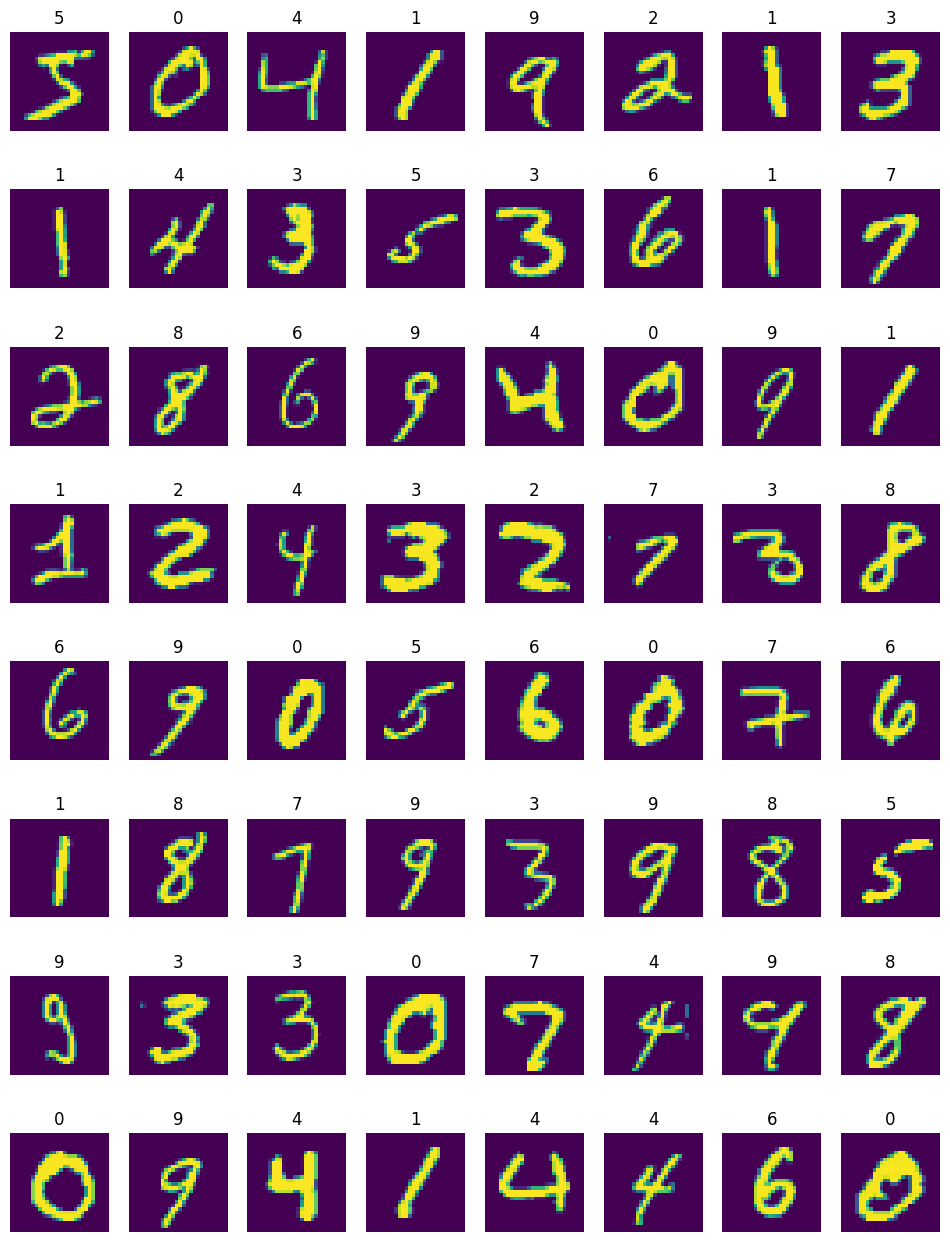

In [ ]:
plt.figure(figsize=(12,16))
for i in range(48):
  plt.subplot(8,8, i+1)
  plt.imshow(batch[0][i,0,:,:])
  plt.title(batch[1][i].item())
  plt.axis("off")

## Build CNN Model

In [ ]:
# conv layer, max pool, cov layer max pool, linear layer, linear layer
from torch.optim.lr_scheduler import ExponentialLR


class CNNs(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,20, 3, 1, 1)
    self.conv2 = nn.Conv2d(20, 50, 3, 1, 1)
    self.linear1 = nn.Linear(50*7*7,100)
    self.linear2 = nn.Linear(100,10)


  def forward(self, x):
    #feature extractor
    #x--->(1, 28,28)
    x = self.conv1(x)
    x1 = torch.relu(x)
    #x---->(20,28,28)
    x = F.max_pool2d(x1, (2,2))
    #x---->(20, 14, 14)
    x = self.conv2(x)
    x2 = torch.relu(x)
    #x---->(50, 14,14)
    x = F.max_pool2d(x2, (2,2))
    #x---->(50,7,7)
    x = x.view(-1,50*7*7)
    #classifier
    x = self.linear1(x)
    x = torch.relu(x)
    x = self.linear2(x)
    #x = torch.softmax(x) # we usually don't use this
    return x, x1, x2




## Train the model

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 9.0000e-02.
Adjusting learning rate of group 0 to 8.1000e-02.
Adjusting learning rate of group 0 to 7.2900e-02.
Adjusting learning rate of group 0 to 6.5610e-02.
Adjusting learning rate of group 0 to 5.9049e-02.


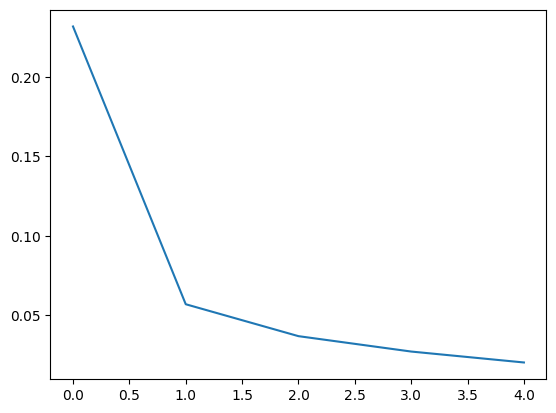

In [ ]:
device = torch.device("cuda:0")
net = CNNs().to(device)

num_epochs = 5
lr = 0.1
momentum = 0.5

opt = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
sch = ExponentialLR(opt, 0.9, verbose = True)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X,y = batch[0].to(device), batch[1].to(device)
    yhat = net(X)[0]
    loss = F.cross_entropy(yhat, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss/len(train_loader))
  sch.step()


plt.plot(ls)

In [ ]:
batch = next(iter(test_loader))
X = batch[0].to(device)
with torch.no_grad():
  Yhat, X1, X2 = net(X)


In [ ]:
print(X1.shape, X2.shape)

torch.Size([64, 20, 28, 28]) torch.Size([64, 50, 14, 14])


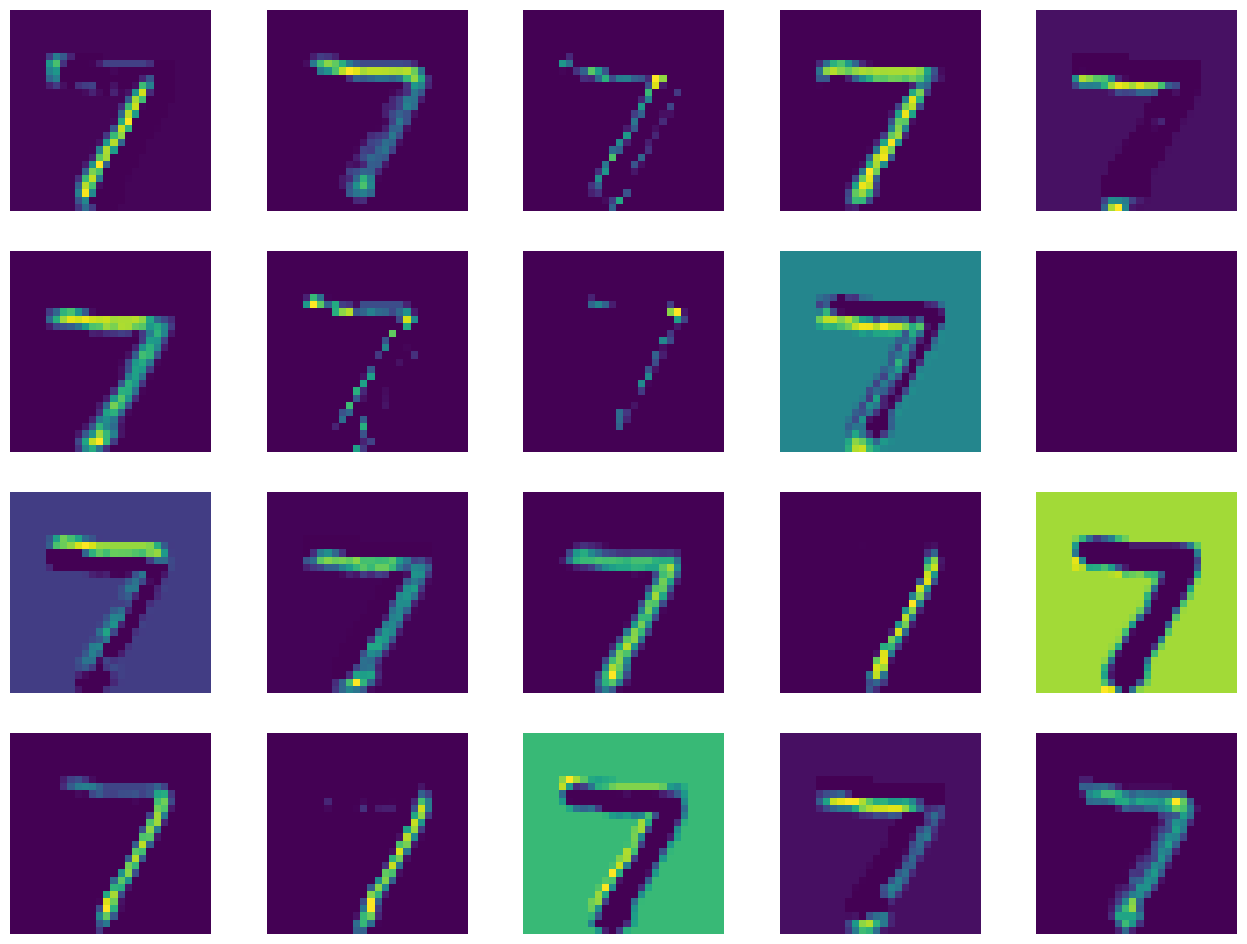

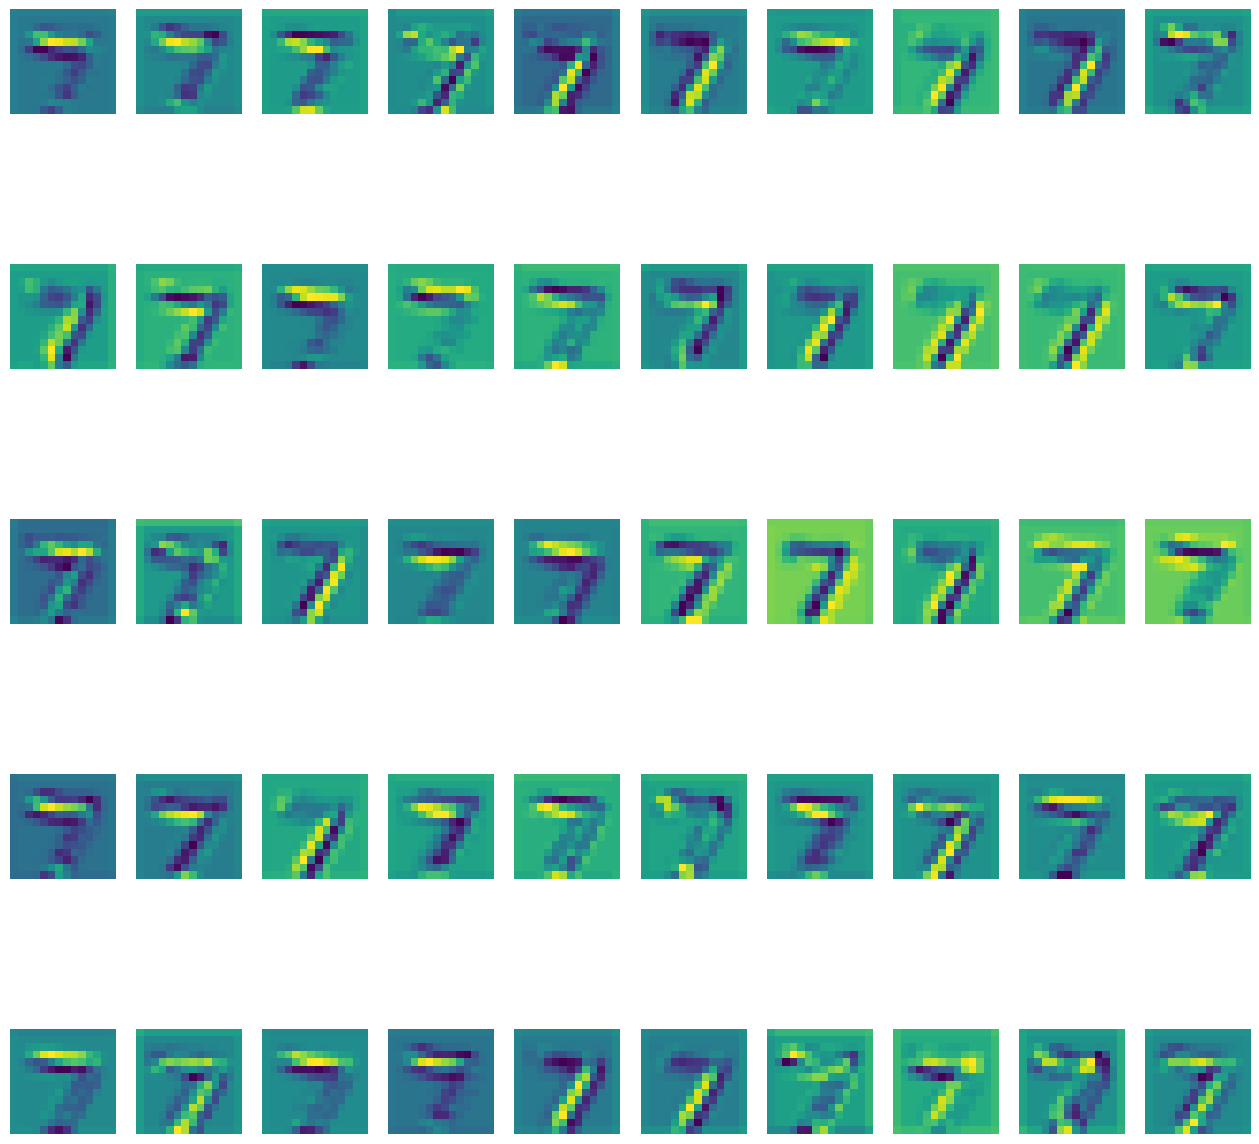

In [ ]:
n = 0
plt.figure(figsize=(16,12))
for i in range(X1.shape[1]):
  plt.subplot(4,5,i+1)
  plt.imshow(X1.cpu()[n,i,:,:])
  plt.axis("off")


plt.figure(figsize=(16,16))
for i in range(X2.shape[1]):
  plt.subplot(5,10,i+1)
  plt.imshow(X2.cpu()[n,i,:,:])
  plt.axis("off")

## Testing

In [ ]:
Xs = []
ys = []
yhats = []
with torch.no_grad():
  for batch in test_loader:
    X,y = batch[0].to(device), batch[1].to(device)
    yhat = net(X)
    label = torch.argmax(yhat[0], dim= 1)
    ind_incorrect = label!=y
    sample = X[ind_incorrect,:,:,:]
    groundTruth = y[ind_incorrect]
    Xs.append(sample)
    ys.append(groundTruth)
    yhats.append ( label[ind_incorrect])



In [ ]:
for i, element in enumerate(Xs):
  if element.shape[0] > 0:
    sam = Xs[i]
    gt = ys[i]
    lab = yhats[i]

In [ ]:
sam.shape

torch.Size([1, 1, 28, 28])

Text(0.5, 1.0, 'tensor(5)')

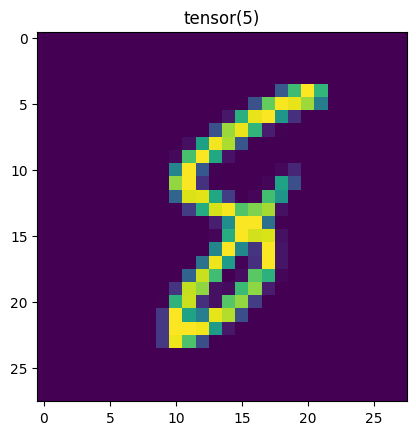

In [ ]:
plt.imshow(sam.cpu()[0,0,:,:])
plt.title(lab.cpu()[0])